In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import roc_curve, auc
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from tqdm import tqdm

from models.sfcn_original import SFCN

import sys

sys.path.append("..")
from utils.datasets import TorchDataset as TD

In [14]:
mode = "test"
dataloader = DataLoader(TD(f"/data/Data/PD/{mode}"), batch_size=8, shuffle=False)

In [15]:
model = SFCN(output_dim=1, channel_number=[28, 58, 128, 256, 256, 64]).to("cuda")
checkpoint = torch.load("checkpoints/PD-SFCN/best_model.pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def accuracy(y_true, y_pred, threshold=0.5):
    y_pred = y_pred > threshold
    return np.mean(y_pred == y_true)

In [17]:
@torch.no_grad()
def test(model, dataloader, device="cuda"):
    model.eval()

    pd_true = []
    pd_pred = []
    study = []
    sex = []
    scanner = []
    for batch in tqdm(dataloader, desc="Test"):
        x = batch[0].to(device)
        pd_true += batch[1].tolist()
        sex += batch[2].tolist()
        study += batch[3].tolist()
        scanner += batch[4].tolist()

        # Forward pass with mixed precision
        with autocast():
            pd_pred += model(x).detach().cpu().tolist()

    return pd_true, pd_pred, sex, study, scanner

In [18]:
pd_true, pd_pred, sex, study, scanner = test(model, dataloader)

Test: 100%|██████████| 42/42 [00:07<00:00,  5.92it/s]


In [19]:
pd_pred = sigmoid(np.array(pd_pred).flatten())
pd_true = np.array(pd_true).flatten()
acc = accuracy(pd_true, pd_pred)

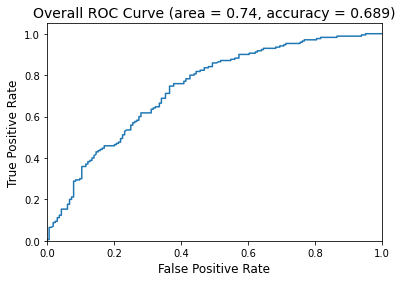

In [20]:
fpr, tpr, thresholds = roc_curve(pd_true, pd_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Overall ROC curve (area = {roc_auc})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(
    f"Overall ROC Curve (area = {round(roc_auc, 2)}, accuracy = {round(acc, 3)})",
    fontsize=14,
)
plt.savefig(f"/data/Papers/MICCAI-biases/subgroup-analysis/overall.pdf", dpi=300)

In [21]:
import pandas as pd

df = pd.DataFrame(
    {
        "pd_true": pd_true,
        "pd_pred": pd_pred,
        "Sex": sex,
        "Site": study,
        "scanner": scanner,
    }
)
df

,pd_true,pd_pred,Sex,Site,scanner
0,1,0.702224,1,3,2
1,0,0.349089,1,1,1
2,0,0.423220,1,0,0
3,0,0.682468,0,8,7
4,0,0.649134,1,6,5
...,...,...,...,...,...
329,1,0.871803,1,4,3
330,1,0.470144,0,5,4
331,0,0.651909,0,1,1
332,1,0.489099,1,8,7


In [27]:
def compute_subgroup_rocs(
    df, y_true_col="pd_true", y_prob_col="pd_pred", subgroup_col="scanner"
):
    unique_scanners = df[subgroup_col].unique()

    metrics = {}
    for scanner in unique_scanners:
        scanner_df = df[df[subgroup_col] == scanner]
        y_true = scanner_df[y_true_col]
        y_prob = scanner_df[y_prob_col]

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)

            metrics[scanner] = {
                "fpr": fpr,
                "tpr": tpr,
                "thresholds": thresholds,
                "auc": roc_auc,
                "total_samples": len(scanner_df),
            }

        except ValueError as e:
            print(f"Error computing ROC for {subgroup_col} {scanner}: {e}")

    return metrics

In [28]:
site_metrics = compute_subgroup_rocs(df, subgroup_col="Site")
sex_metrics = compute_subgroup_rocs(df, subgroup_col="Sex")

In [32]:
site_rocs = [site_metrics[i]["auc"] for i in range(len(site_metrics))]
sex_rocs = [sex_metrics[0]["auc"], sex_metrics[1]["auc"]]

In [56]:
sex_rocs

[0.6575342465753424, 0.7943331178625296]

<Figure size 720x288 with 0 Axes>

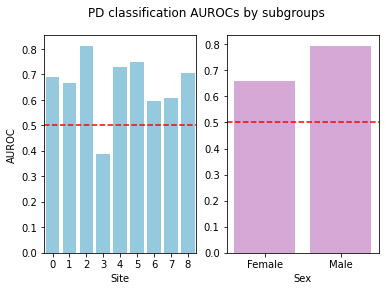

In [57]:
plt.figure(figsize=(10, 4))
fig, ax = plt.subplots(1, 2)
sns.barplot(x=np.arange(9), y=site_rocs, ax=ax[0], color="skyblue")
ax[0].set(xlabel="Site", ylabel="AUROC")
ax[0].axhline(0.5, color="red", linestyle="--", label="Chance level")

sns.barplot(x=["Female", "Male"], y=sex_rocs, ax=ax[1], color="plum")
ax[1].set(xlabel="Sex")
ax[1].axhline(0.5, color="red", linestyle="--", label="Chance level")

fig.suptitle("PD classification AUROCs by subgroups")

plt.savefig(f"/data/Papers/MICCAI-biases/subgroup-analysis/subgroups.pdf", dpi=300)
